In [4]:
import sqlite3
import pandas as pd
import itertools
from scipy.stats import mannwhitneyu
import logging

# Configurar logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# --- 1. Conexión a la base de datos y extracción de datos ---
db_path = "../../db/audio_metadata.db"
conn = sqlite3.connect(db_path)
# Extraer los registros procesados de la tabla audio_metadata
df = pd.read_sql_query("SELECT * FROM audio_metadata WHERE processed = TRUE", conn)
conn.close()

# Lista de índices a evaluar
indices = ["ACI", "ADI", "AEI", "BIO", "NDSI", "H", "AR"]

# Filtrar filas que tengan datos en todos los índices y en "recorder"
df_indices = df.dropna(subset=indices + ["recorder"])

# --- 2. Comparaciones pairwise con Mann–Whitney U ---
# Obtener la lista única de grabadoras
recorders = df_indices["recorder"].unique()

results = []
alpha = 0.05  # Nivel de significación

for r1, r2 in itertools.combinations(recorders, 2):
    for idx in indices:
        sample1 = df_indices[df_indices["recorder"] == r1][idx].dropna().values
        sample2 = df_indices[df_indices["recorder"] == r2][idx].dropna().values

        # Solo realizar el test si ambos grupos tienen datos
        if len(sample1) > 0 and len(sample2) > 0:
            stat, p_val = mannwhitneyu(sample1, sample2, alternative="two-sided")
            decision = "Aceptado" if p_val >= alpha else "Rechazado"
            results.append({
                "recorder1": r1,
                "recorder2": r2,
                "feature": idx,  # Renombramos 'index' a 'feature'
                "statistic": stat,
                "p_value": p_val,
                "decision": decision,
                "alpha": alpha  # Añadir el valor de alfa
            })
            logging.info(f"{idx}: Comparación {r1} vs {r2} -> p_value = {p_val:.4f} => {decision}")

# Convertir los resultados a un DataFrame y ordenarlo por p-valor
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="p_value").reset_index(drop=True)

logging.info("Resultados de los contrastes Mann–Whitney (ordenados por p-valor):")
logging.info("\n" + results_df.to_string())

# --- 3. Guardar los resultados en la base de datos ---
conn = sqlite3.connect(db_path)
cur = conn.cursor()

# Crear la tabla "mann_whitney_results" si no existe (se renombra la columna 'index' a 'feature')
create_table_query = """
CREATE TABLE IF NOT EXISTS mann_whitney_results (
    recorder1 TEXT,
    recorder2 TEXT,
    feature TEXT,
    statistic REAL,
    p_value REAL,
    decision TEXT,
    alpha REAL
);
"""
cur.execute(create_table_query)
conn.commit()

# Insertar los resultados en la tabla (sobrescribe la tabla con los nuevos resultados)
results_df.to_sql("mann_whitney_results", conn, if_exists="replace", index=False)

conn.close()

logging.info("Los resultados se han guardado en la tabla 'mann_whitney_results' de la base de datos.")

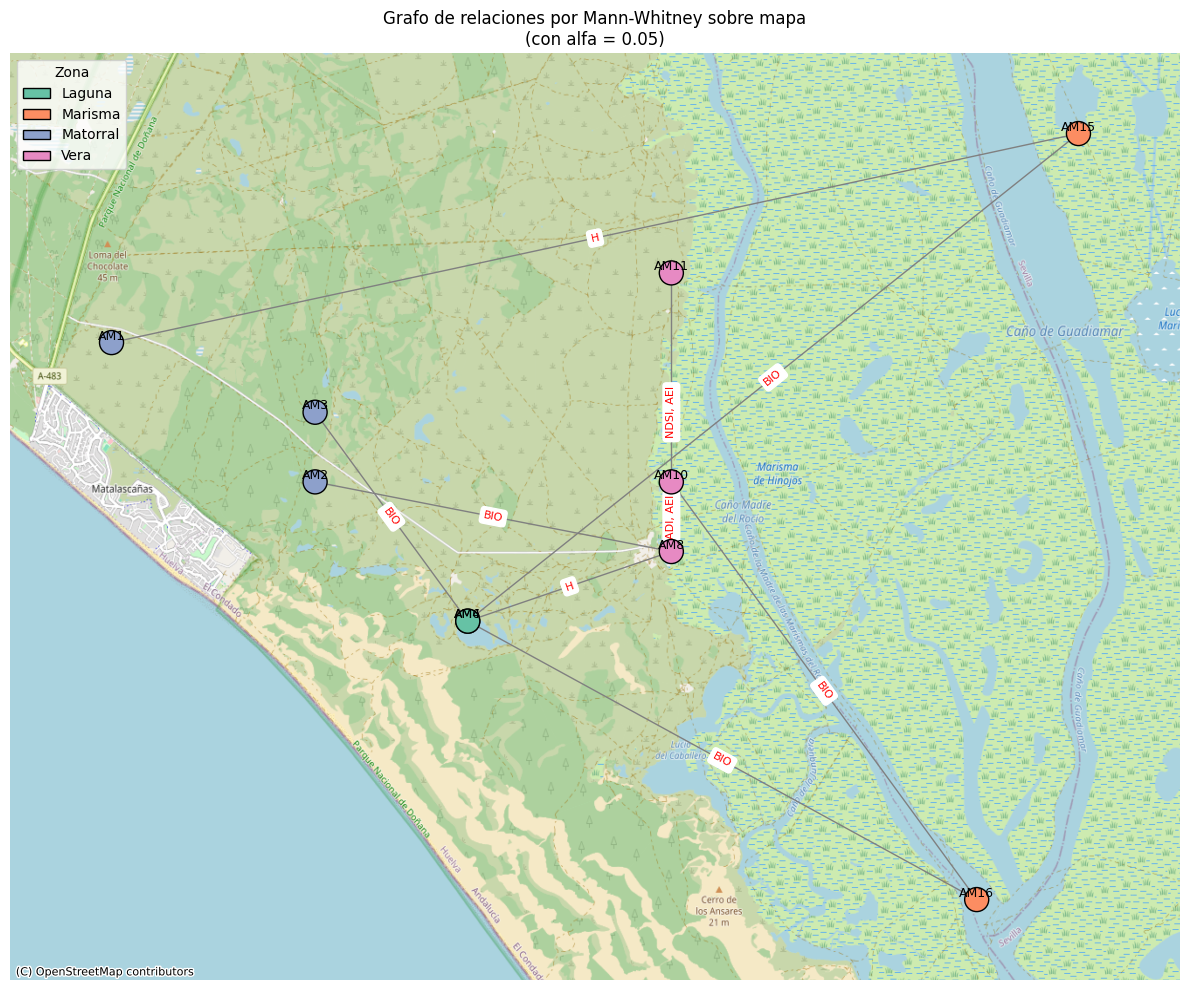

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import pandas as pd
import sqlite3
import geopandas as gpd
import contextily as ctx
import logging

# --- 1. Extraer resultados de Mann–Whitney y metadata de zonas ---
db_path = "../../db/audio_metadata.db"
conn = sqlite3.connect(db_path)

df_mw_accepted = pd.read_sql_query("SELECT * FROM mann_whitney_results WHERE decision = 'Aceptado'", conn)
df_meta = pd.read_sql_query("SELECT recorder, name, zone, lat, lon FROM recorders WHERE recorder IS NOT 'AM22'", conn)
conn.close()

# Tomar solo una aparición por grabadora
df_zones = df_meta.drop_duplicates(subset=["recorder"])

# Diccionario para zonas, latitudes y longitudes
recorder_to_zone = dict(zip(df_zones["recorder"], df_zones["zone"]))
recorder_to_coords = dict(zip(df_zones["recorder"], zip(df_zones["lon"], df_zones["lat"])))

logging.info(f"Grabadoras y zonas: {recorder_to_zone}")

# --- 2. Crear grafo ---
G = nx.Graph()

# Nodos con atributos de zona y posición (lon, lat)
for recorder, zone in recorder_to_zone.items():
    lon, lat = recorder_to_coords[recorder]
    G.add_node(recorder, zone=zone, pos=(lon, lat))

# Agregar aristas con features
for _, row in df_mw_accepted.iterrows():
    r1 = row["recorder1"]
    r2 = row["recorder2"]
    feature = row["feature"]
    if G.has_edge(r1, r2):
        G[r1][r2]["features"].append(feature)
    else:
        G.add_edge(r1, r2, features=[feature])

# Convertir features a cadena para etiquetas
for u, v, data in G.edges(data=True):
    data["label"] = ", ".join(data["features"])

# Extraer posiciones en diccionario
pos = {node: data["pos"] for node, data in G.nodes(data=True)}

# --- 3. Crear GeoDataFrame para contexto del mapa ---
gdf_nodes = gpd.GeoDataFrame(df_zones, geometry=gpd.points_from_xy(df_zones["lon"], df_zones["lat"]), crs="EPSG:4326")
gdf_nodes = gdf_nodes.to_crs(epsg=3857)  # Web Mercator para usar con contextily
node_coords_3857 = {recorder: (geom.x, geom.y) for recorder, geom in zip(gdf_nodes["recorder"], gdf_nodes.geometry)}

# Actualizar posiciones con coordenadas proyectadas
pos_proj = {recorder: node_coords_3857[recorder] for recorder in G.nodes()}

# --- 4. Graficar el grafo sobre mapa ---
plt.figure(figsize=(12, 10))

ax = plt.gca()

# Dibujar nodos con color por zona
sorted_zones = sorted(df_indices["zone"].unique())
palette = sns.color_palette("Set2", n_colors=len(sorted_zones))
zone_colors = dict(zip(sorted_zones, palette))


node_colors = [zone_colors[G.nodes[node]["zone"]] for node in G.nodes()]

nx.draw_networkx_nodes(G, pos_proj, node_color=node_colors, node_size=300, ax=ax, edgecolors='black')
nx.draw_networkx_labels(G, pos_proj, font_size=9, ax=ax, verticalalignment='bottom')

# Dibujar aristas
nx.draw_networkx_edges(G, pos_proj, edge_color='gray', ax=ax)

# Dibujar etiquetas en aristas
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos_proj, edge_labels=edge_labels, font_color='red', font_size=8, ax=ax)

# Añadir el mapa base de contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=13)


# Leyenda personalizada para colores por zona
legend_elements = [Patch(facecolor=color, edgecolor='black', label=zone) for zone, color in zone_colors.items()]
plt.legend(handles=legend_elements, title="Zona", loc="best")

plt.title("Grafo de relaciones por Mann-Whitney sobre mapa\n(con alfa = 0.05)")
plt.axis("off")
plt.tight_layout()
plt.show()